# Modeling the growth of COVID-19

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import pymc3

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Read the time series as a CSV from ESRI AGOL:

In [2]:
TIME_SERIES_URL = (
    "http://lahub.maps.arcgis.com/sharing/rest/content/items/"
    "f912069273894509b7fcb5c71fae2366/data"
)

df = pandas.read_csv(
    TIME_SERIES_URL,
    parse_dates=["date"],
).sort_values("date")

Subset to LA County and drop the last date which might not have been
updated yet.

In [3]:
la = (
    df[df.county == "Los Angeles"]
    .reset_index(drop=True)
    .iloc[:-1]
)

Compute the number of days since the number of cases reached a threshold,
here we choose 10.

In [4]:
# Start modeling once the cases reach a certain threshhold.
# In this case, arbitrarily choose 20 cases
START_CASES = 20

# Number of days to model when extrapolating
N_MODEL_DAYS = 40

idx = (la.cases - START_CASES).abs().idxmin()
start_date = la.date.iloc[idx]
end_date = start_date+pandas.Timedelta(days=N_MODEL_DAYS-1)
la = (
    la[la.date >=start_date]
    .assign(days_since_start=(la.date-start_date).dt.days)
    .reset_index(drop=True)
)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


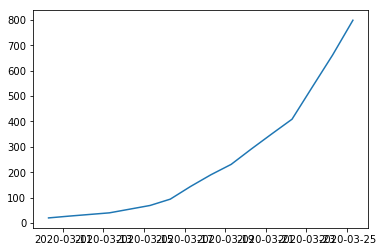

In [5]:
plt.plot(la.date.values, la.cases.values)

Create the Bayesian model.

In [6]:
with pymc3.Model() as model:
    # Model the initial value as a random variable
    # with an exponential prior. This distribution
    # has a mean of START_CASES, but we allow it to
    # be different to account for measurement error.
    a = pymc3.Exponential(
        'a',
        lam=1./START_CASES,
    )
    # Model the doubling timescale as another random variable
    # with exponential prior. The mean of the distribution
    # is chosen to be a 5 day doubling time.
    tau = pymc3.Exponential(
        'tau', 
        lam=1./5.,
    )
    

            
    # By using pm.Data we can change these values after sampling.
    # This allows us to extend x into the future so we can get
    # forecasts by sampling from the posterior predictive
    x = pymc3.Data("x_data", la.days_since_start.values)
    cases = pymc3.Data("y_data", la.cases.values)
    
    # Model likelihood of observed counts with a Poisson distribution.
    # This is likely too inflexible as it does not allow variance to be
    # specified independently of mean, but we don't have a good way to
    # model variance right now anyways.
    pymc3.Poisson(
        'counts', 
        (a * 2. ** (x/tau)), # Exponential regression
        observed=cases
    )
    
    display(model)

In [7]:
with model:
    # Sample posterior
    trace = pymc3.sample(draws=5000, tune=1500, chains=1, cores=1, target_accept=.9)
    
    # Update data so that we get predictions into the future
    x_data = numpy.arange(0, N_MODEL_DAYS)
    y_data = numpy.array([numpy.nan] * len(x_data))
    pymc3.set_data({"x_data": x_data})
    pymc3.set_data({"y_data": y_data})
    
    # Sample posterior predictive
    post_pred = pymc3.sample_posterior_predictive(trace, samples=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tau, a]
Sampling chain 0, 0 divergences: 100%|██████████| 6500/6500 [00:07<00:00, 847.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:03<00:00, 129.08it/s]


In [8]:
last_day = post_pred['counts'][:,-1]
idx_q75 = numpy.argmin(numpy.abs(last_day-numpy.quantile(last_day, 0.75)))
idx_q50 = numpy.argmin(numpy.abs(last_day-numpy.quantile(last_day, 0.50)))
idx_q25 = numpy.argmin(numpy.abs(last_day-numpy.quantile(last_day, 0.25)))

q25 = post_pred['counts'][idx_q25, :]
q50 = post_pred['counts'][idx_q50, :]
q75 = post_pred['counts'][idx_q75, :]

In [9]:
import matplotlib
matplotlib.style.use('bmh')

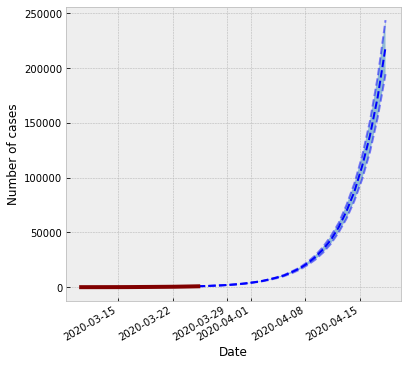

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
daterange = pandas.date_range(
    start=start_date,
    end=end_date,
)
ax.plot(daterange.values, q25, '--', alpha=0.5, color='blue')
ax.plot(daterange.values, q50, '--', color='blue')
ax.plot(daterange.values, q75, '--', alpha=0.5, color='blue')
ax.fill_between(daterange.values, q75, q25, alpha=0.5)

ax.plot(la.date, la.cases,'-', lw=4, color='maroon')

ax.set_xlabel("Date")
ax.set_ylabel("Number of cases")
fig.autofmt_xdate()
fig.show()
plt.savefig("extrapolation.png", dpi=300, bbox="tight")

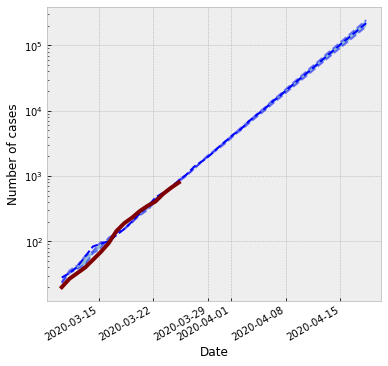

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
daterange = pandas.date_range(
    start=start_date,
    end=end_date,
)
ax.semilogy(daterange.values, q25, '--', alpha=0.5, color='blue')
ax.semilogy(daterange.values, q50, '--', color='blue')
ax.semilogy(daterange.values, q75, '--', alpha=0.5, color='blue')
ax.fill_between(daterange.values, q75, q25, alpha=0.5)

ax.semilogy(la.date, la.cases,'-', lw=4, color='maroon')

ax.set_xlabel("Date")
ax.set_ylabel("Number of cases")
fig.autofmt_xdate()
fig.show()
plt.savefig("extrapolation-semilog.png", dpi=300, bbox="tight")

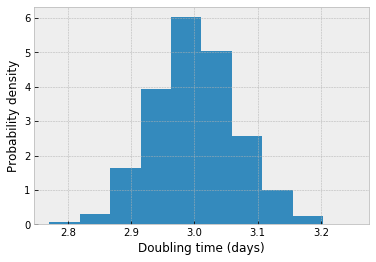

In [12]:
fig, ax = plt.subplots()
ax.hist(trace.tau, density=True)
ax.set_xlabel("Doubling time (days)")
ax.set_ylabel("Probability density")
fig.show()
plt.savefig("timescale.png", dpi=300, bbox="tight")